In [1]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import pathlib
from fastai.vision.all import *

BASE_DIR = pathlib.Path().resolve().parent
DATA_DIR = BASE_DIR.joinpath('data')
TRAIN_DATA_DIR = DATA_DIR.joinpath('train')
TEST_DATA_DIR = DATA_DIR.joinpath('test')
SRC_DIR = BASE_DIR.joinpath('src')

In [2]:
train_df = pd.read_csv(TRAIN_DATA_DIR.joinpath('train.csv'))#.reindex(['filename', 'label'], axis=1)
train_df['label'] = train_df['label'].map({1:"crack", 2:"scratch", 3:"tire_flat", 4:"dent", 5:"glass_shatter", 6:"lamp_broken"})
train_df.sample()

,image_id,filename,label
5289,5290,5290.jpg,dent


In [3]:
X = train_df[['image_id', 'filename']]
y = train_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5760, 2), (1440, 2), (5760,), (1440,))

In [4]:
y_train.value_counts()

label
scratch          1879
dent             1663
glass_shatter     948
lamp_broken       706
tire_flat         427
crack             137
Name: count, dtype: int64

In [5]:
y_test.value_counts()

label
scratch          470
dent             416
glass_shatter    237
lamp_broken      176
tire_flat        107
crack             34
Name: count, dtype: int64

In [6]:
# Let's define some functions before defining datablock
def get_x(r):
    return TRAIN_DATA_DIR.joinpath('images').joinpath(r['filename'])

def get_y(r):
    return r['label'].split(' ')
    
def splitter(df):
    train = df.index[X_train.index].tolist()
    valid = df.index[X_test.index].tolist()
    return train, valid
    
# Datablock Object
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=splitter,
    item_tfms=Resize(128, ResizeMethod.Squish),
    # batch_tfms=[*aug_transforms()]
)

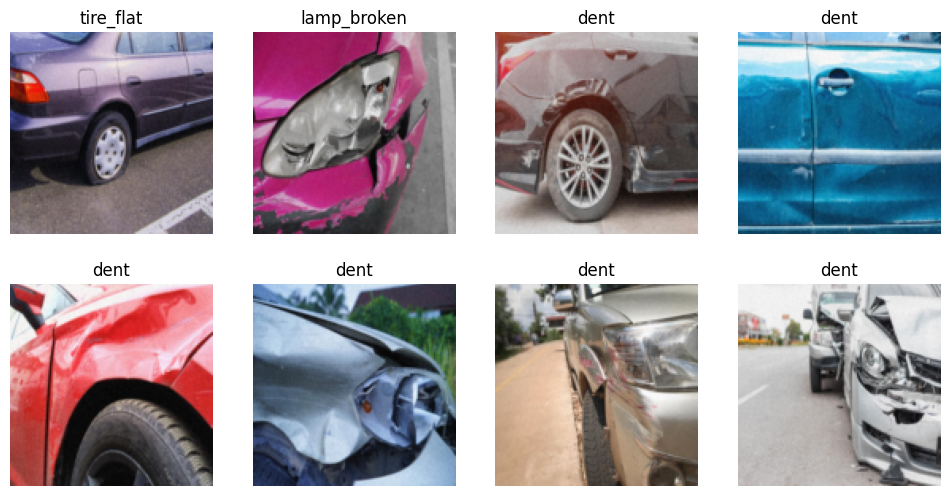

In [7]:
# Create dataloaders by spcifying the batch_size and data source
dls = dblock.dataloaders(train_df, bs=64) #, drop_last=True

# Visualize some samples in a batch
dls.show_batch(nrows=2, ncols=4) # , max_n=8

In [8]:
dls.vocab

['crack', 'dent', 'glass_shatter', 'lamp_broken', 'scratch', 'tire_flat']

In [9]:
# f1_score_multi = F1Score(average="macro")

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


SuggestedLRs(valley=0.001737800776027143)

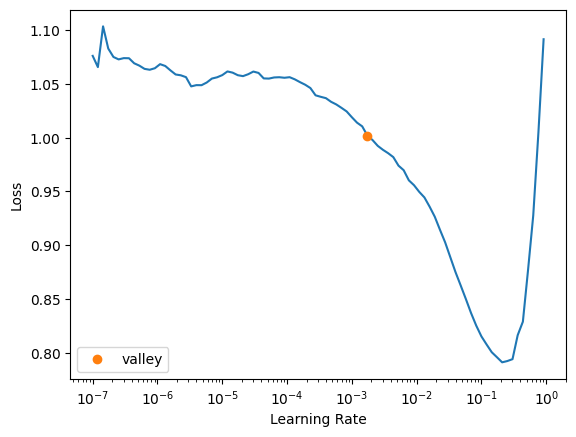

In [10]:
# Create a learner with resnet50
learn = vision_learner(dls, models.resnet152, metrics=partial(accuracy_multi, thresh=0.5))
# F1ScoreMulti, partial(accuracy_multi, thresh=0.2)
learn.lr_find()

In [11]:
# # # learn.unfreeze()
# BASELINE_MODEL_PATH = BASE_DIR.joinpath('model/Bmodel_fastai_resnet152_sampled_8020_lr_33.h5')
# learn = load_learner(BASELINE_MODEL_PATH)

In [ ]:
learn.fine_tune(3, base_lr=1e-4, freeze_epochs=3)

In [31]:
# learn.save('stage-1') # 0.043920	0.079809	0.970602
# learn.save('stage-2') # 0.029643	0.071413	0.974074
# learn.save('stage-3') # 0.005, 0.04

Path('models/stage-2.pth')

In [32]:
# learn.fit_one_cycle(1, 2e-3) # , div=32

In [33]:
# learn.unfreeze()
# learn.fit_one_cycle(6, lr_max=slice(2e-3, 1e-1))

In [34]:
# learn.show_results(1, max_n=8)

,target,predicted,probabilities,loss
0,glass_shatter,dent,"tensor([2.7271e-03, 9.9213e-01, 3.6939e-02, 4.9021e-03, 1.4050e-03, 2.3744e-04])",1.358687162399292
1,dent,scratch,"tensor([3.3941e-03, 5.8579e-02, 6.4082e-04, 1.4692e-02, 9.9334e-01, 3.0528e-03])",1.311797857284546
2,glass_shatter,dent,"tensor([3.4875e-03, 9.9525e-01, 8.3920e-02, 2.5973e-03, 3.6657e-04, 2.7082e-04])",1.3056609630584717
3,scratch,dent,"tensor([1.4515e-02, 8.4036e-01, 7.3434e-04, 9.4294e-02, 5.0278e-03, 4.4896e-03])",1.2077538967132568
4,scratch,dent,"tensor([1.4425e-02, 9.6157e-01, 6.8257e-04, 1.6925e-03, 2.9860e-02, 1.9174e-03])",1.1315016746520996
5,lamp_broken,scratch,"tensor([1.8249e-03, 9.5123e-04, 4.0861e-04, 1.8599e-02, 9.1846e-01, 1.3126e-03])",1.082629680633545
6,crack,scratch,"tensor([0.0963, 0.0056, 0.0017, 0.0210, 0.9789, 0.0042])",1.0389153957366943
7,scratch,dent,"tensor([0.0122, 0.6250, 0.0037, 0.1691, 0.0066, 0.0156])",1.0356237888336182
8,glass_shatter,dent,"tensor([1.2475e-02, 8.2860e-01, 1.4242e-02, 4.2418e-02, 7.7558e-03, 5.8441e-04])",1.0132646560668945


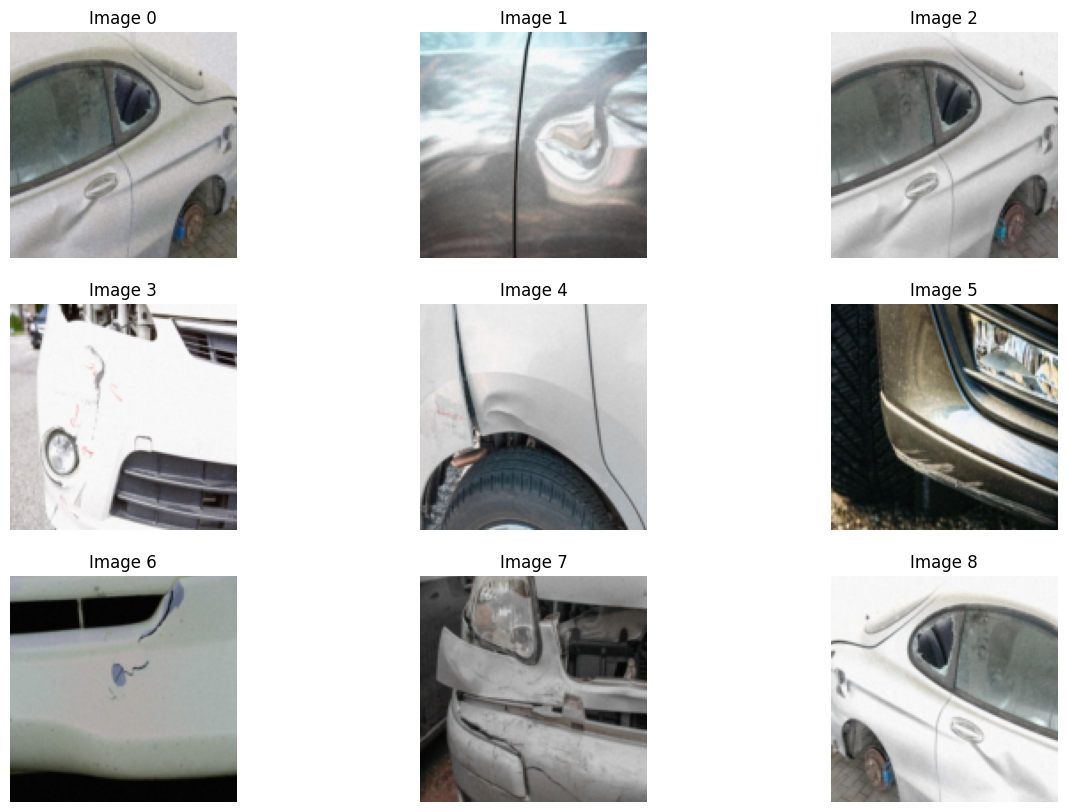

In [35]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))


In [20]:
# # Check for different thresholds
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# accuracies_by_thresh = []
# for threshold in thresholds:
    
#     learn.metrics = partial(accuracy_multi, thresh=threshold)
#     validations = learn.validate()
#     accuracies_by_thresh.append({"threshold": threshold, "accuracy": validations[1]})

# accuracies_by_thresh_df = pd.DataFrame(accuracies_by_thresh)
# accuracies_by_thresh_df

In [36]:
learn.freeze()
BASELINE_MODEL_PATH = BASE_DIR.joinpath('model/Bmodel_fastai_resnet152_0.02_0.07_0.97.h5')
learn.export(BASELINE_MODEL_PATH)

In [37]:
# BASELINE_MODEL_PATH = BASE_DIR.joinpath('model/Bmodel_fastai_resnet152_sampled_8020_lr_33.h5')
# learn = load_learner(BASELINE_MODEL_PATH)

In [38]:
img_path = TEST_DATA_DIR/'images/7313.jpg'
print(dls.vocab[np.argmax(learn.predict(img_path)[2])])
# img = Image.open(img_path)
# img.show()

dent


In [39]:
test_df = pd.read_csv(TEST_DATA_DIR.joinpath('test.csv'))#.reindex(['filename', 'label'], axis=1)
print(test_df.shape)
test_df.sample()

(4800, 2)


,image_id,filename
2800,10001,10001.jpg


In [ ]:
results = []
for img_path in list(TEST_DATA_DIR.joinpath('images').iterdir()):

    # img = Image.open(img_path)
    # img.show()

    # print(img_path.stem, img_path)

    preds = learn.predict(img_path)
    results.append({"image_id": img_path.stem, "label": dls.vocab[np.argmax(preds[2])]})

submission_df = pd.DataFrame(results)
submission_df

In [ ]:
submission_df['label'].value_counts()

In [ ]:
submission_df['label'] = submission_df['label'].map({"crack":1, "scratch":2, "tire_flat":3, "dent":4, "glass_shatter":5, "lamp_broken":6})
submission_df

In [ ]:
submission_df.to_csv(DATA_DIR/f'submission{datetime.now().strftime("%Y%m%dT%H%M")}.csv', index=False)